In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT

C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [8]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
image_size = 128
batch_size = 64
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=15,          # 小角度旋轉
            translate=(0.1, 0.1),# 平移最多 10%
            scale=(0.9, 1.1),    # 縮放 +/- 10%
            shear=10             # 仿射變形
        )
    ], p=0.1),
    transforms.Resize((image_size, image_size)),
    # transforms.RandomApply([
    #     transforms.ColorJitter(contrast=0.25, brightness=0.5)
    # ], p=0.8), 
    # transforms.RandomApply([
    #     transforms.GaussianBlur(kernel_size=3)
    # ], p=0.8),  
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
])
train_dataset = Thyroid_Dataset("finetune_train_DDTI_v4(0.9).csv", transform = train_transform, return_from_dataset = True, crop_DDTI = True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("finetune_test_DDTI_v4(0.9).csv", transform = test_transform, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
image, mask, seg_type, from_dataset = next(iter(train_dataloader))
image = image
mask = mask

In [11]:
print(len(train_dataloader), len(test_dataloader))

9 1


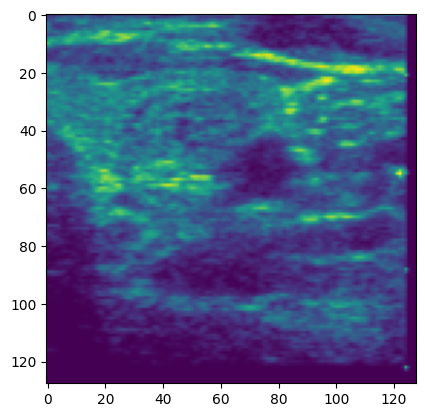

In [12]:
plt.imshow(image[10][0])

In [13]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)


        
        loss = nodule_loss
        IOU = IOU_score(nodule_output, nodule_mask) 

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
    

        total_loss += nodule_loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [14]:
epochs = 50
lr = 0.04
project = "thyroid"
name="PMFSNet_finetune_baseline_v4(0.9)_aug_Affine_lr_0.04"
# name = "PMFSNet_baseline_v4(0.9)"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.04, epochs : 50, batch size : 64


In [16]:
inference_name = "PMFSNet_baseline"
# # model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [18]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.10it/s]

train loss : 1.7683500779999628, train IOU : 0.4137626323435042, train DICE : 0.5704518026775784



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.75it/s]

val loss : 2.0864877700805664, val IOU : 0.2709253430366516, val DICE : 0.4375718832015991
epoch : 1



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.14it/s]

train loss : 0.8626268439822726, train IOU : 0.4632774790128072, train DICE : 0.5745885637071397



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]

val loss : 1.398688793182373, val IOU : 0.36493661999702454, val DICE : 0.5458880662918091
epoch : 2



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.33it/s]

train loss : 0.7671674556202359, train IOU : 0.5083813336160448, train DICE : 0.6510871450106303



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]

val loss : 1.0483981370925903, val IOU : 0.4184196889400482, val DICE : 0.6000574231147766
epoch : 3



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.43it/s]

train loss : 0.7135808732774522, train IOU : 0.5419030520651076, train DICE : 0.6779602501127455



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]

val loss : 0.8166873455047607, val IOU : 0.4828747510910034, val DICE : 0.6598774790763855
epoch : 4



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.30it/s]

train loss : 0.6824846996201409, train IOU : 0.5601697961489359, train DICE : 0.7070133421156142



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.91it/s]

val loss : 0.8082172274589539, val IOU : 0.48588061332702637, val DICE : 0.6698996424674988
epoch : 5



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.35it/s]

train loss : 0.6526690721511841, train IOU : 0.5848835110664368, train DICE : 0.7196638716591729



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.26it/s]

val loss : 0.7700397968292236, val IOU : 0.5250202417373657, val DICE : 0.6828775405883789
epoch : 6



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.30it/s]

train loss : 0.6061011221673753, train IOU : 0.6152292821142409, train DICE : 0.7559881607691447



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.26it/s]

val loss : 0.7845251560211182, val IOU : 0.5247628092765808, val DICE : 0.6855177879333496
epoch : 7



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.27it/s]

train loss : 0.5815320743454827, train IOU : 0.6289768218994141, train DICE : 0.7643750773535835



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]

val loss : 0.8513134717941284, val IOU : 0.4871942102909088, val DICE : 0.6473386883735657
epoch : 8



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.32it/s]

train loss : 0.5768675340546502, train IOU : 0.6382835507392883, train DICE : 0.7708684272236295



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]

val loss : 0.7095933556556702, val IOU : 0.5732777118682861, val DICE : 0.7017287015914917
epoch : 9



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.38it/s]

train loss : 0.5439852343665229, train IOU : 0.6536761985884773, train DICE : 0.7855729791853163



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]

val loss : 0.7420024871826172, val IOU : 0.5733106732368469, val DICE : 0.708308219909668
epoch : 10



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.5513616469171312, train IOU : 0.6491809288660685, train DICE : 0.7878581219249301



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]

val loss : 0.7652428150177002, val IOU : 0.5427310466766357, val DICE : 0.6883711814880371
epoch : 11



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.52it/s]

train loss : 0.5086346103085412, train IOU : 0.6816199355655246, train DICE : 0.8042164577378167



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.93it/s]

val loss : 0.7210045456886292, val IOU : 0.5486937761306763, val DICE : 0.7220792174339294
epoch : 12



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.5073791609870063, train IOU : 0.6836925546328226, train DICE : 0.8055837882889642



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]

val loss : 0.7388449907302856, val IOU : 0.5622190237045288, val DICE : 0.7093881368637085
epoch : 13



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.47942102948824566, train IOU : 0.706252654393514, train DICE : 0.8204165895779928



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]

val loss : 0.7618758678436279, val IOU : 0.5581192970275879, val DICE : 0.6889213919639587
epoch : 14



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.55it/s]

train loss : 0.4675130777888828, train IOU : 0.7130799094835917, train DICE : 0.828932887978024



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.65it/s]

val loss : 0.730729341506958, val IOU : 0.5592347383499146, val DICE : 0.709057092666626
epoch : 15



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.51it/s]

train loss : 0.45513202084435356, train IOU : 0.7174885074297587, train DICE : 0.8328345815340678



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]

val loss : 0.6756083965301514, val IOU : 0.5960582494735718, val DICE : 0.735419750213623
epoch : 16



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.43it/s]

train loss : 0.45141781038708156, train IOU : 0.724885900815328, train DICE : 0.8360963861147562



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.39it/s]

val loss : 0.7143769860267639, val IOU : 0.5921395421028137, val DICE : 0.7146967649459839
epoch : 17



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.41it/s]

train loss : 0.4249406125810411, train IOU : 0.740205294556088, train DICE : 0.8473231659995185



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.49it/s]

val loss : 0.7177778482437134, val IOU : 0.5793287754058838, val DICE : 0.7271502017974854
epoch : 18



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.53it/s]

train loss : 0.41076088282797074, train IOU : 0.7572331892119514, train DICE : 0.858611093627082



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.71it/s]

val loss : 0.7113912105560303, val IOU : 0.5917510390281677, val DICE : 0.730527937412262
epoch : 19



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.42it/s]

train loss : 0.39769799841774833, train IOU : 0.7622432377603319, train DICE : 0.8608143064710829



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.25it/s]

val loss : 0.7503641843795776, val IOU : 0.5882755517959595, val DICE : 0.7202042937278748
epoch : 20



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.48it/s]

train loss : 0.3989187545246548, train IOU : 0.7635938061608208, train DICE : 0.8604048622979058



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.16it/s]

val loss : 0.7315340638160706, val IOU : 0.5651748776435852, val DICE : 0.734493613243103
epoch : 21



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.40580227971076965, train IOU : 0.7589435246255662, train DICE : 0.8581560982598199



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]

val loss : 0.7278174757957458, val IOU : 0.582633376121521, val DICE : 0.7287142872810364
epoch : 22



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.53it/s]

train loss : 0.38802773422665066, train IOU : 0.7720789313316345, train DICE : 0.86500393682056



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.62it/s]

val loss : 0.6778802871704102, val IOU : 0.5969443321228027, val DICE : 0.7414934039115906
epoch : 23



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.41it/s]

train loss : 0.38478681445121765, train IOU : 0.7713324493832059, train DICE : 0.8631265097194247



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.60it/s]

val loss : 0.6954969167709351, val IOU : 0.585229754447937, val DICE : 0.7401049733161926
epoch : 24



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.3694138593143887, train IOU : 0.7822688751750522, train DICE : 0.8742189341121249



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.43it/s]

val loss : 0.7189918756484985, val IOU : 0.5739537477493286, val DICE : 0.7298073172569275
epoch : 25



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.55it/s]

train loss : 0.374938428401947, train IOU : 0.7750335600641038, train DICE : 0.8712808688481649



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.18it/s]

val loss : 0.6885460615158081, val IOU : 0.6034526228904724, val DICE : 0.748505175113678
epoch : 26



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.39it/s]

train loss : 0.37182674143049455, train IOU : 0.7799385852283902, train DICE : 0.872436437341902



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.55it/s]

val loss : 0.7155471444129944, val IOU : 0.5866844058036804, val DICE : 0.7365307807922363
epoch : 27



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.44it/s]

train loss : 0.3765731188986037, train IOU : 0.7819012734625075, train DICE : 0.8722868892881606



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.92it/s]

val loss : 0.6906352043151855, val IOU : 0.5983912348747253, val DICE : 0.7482266426086426
epoch : 28



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.49it/s]

train loss : 0.34862614009115434, train IOU : 0.8022559550073411, train DICE : 0.880461593468984



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.24it/s]

val loss : 0.7437129020690918, val IOU : 0.5845158100128174, val DICE : 0.7276571989059448
epoch : 29



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.44it/s]

train loss : 0.3414192001024882, train IOU : 0.8038910494910346, train DICE : 0.8818114731046889



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]

val loss : 0.7417163848876953, val IOU : 0.5714025497436523, val DICE : 0.7266945242881775
epoch : 30



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.53it/s]

train loss : 0.341771211889055, train IOU : 0.8029497928089566, train DICE : 0.8887347976366679



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.86it/s]

val loss : 0.6792808771133423, val IOU : 0.5938887000083923, val DICE : 0.7460975050926208
epoch : 31



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.44it/s]

train loss : 0.36304203338093227, train IOU : 0.7876997722519768, train DICE : 0.8789090050591363



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.13it/s]

val loss : 0.7048337459564209, val IOU : 0.5984287261962891, val DICE : 0.7448811531066895
epoch : 32



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.56it/s]

train loss : 0.3174770772457123, train IOU : 0.816530790593889, train DICE : 0.8955112828148736



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]

val loss : 0.7235229015350342, val IOU : 0.5869796872138977, val DICE : 0.7388148307800293
epoch : 33



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.31it/s]

train loss : 0.35199514362547135, train IOU : 0.8076155119472079, train DICE : 0.883211162355211



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.90it/s]

val loss : 0.6961721181869507, val IOU : 0.5929425954818726, val DICE : 0.7448158264160156
epoch : 34



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.41it/s]

train loss : 0.3047333359718323, train IOU : 0.8269592722256979, train DICE : 0.8984092606438531



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.63it/s]

val loss : 0.7103868722915649, val IOU : 0.589996874332428, val DICE : 0.742310106754303
epoch : 35



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.51it/s]

train loss : 0.31873317062854767, train IOU : 0.8241286211543613, train DICE : 0.8970495793554518



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.80it/s]

val loss : 0.6950860023498535, val IOU : 0.5964915156364441, val DICE : 0.7500305771827698
epoch : 36



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.50it/s]

train loss : 0.31527337266339195, train IOU : 0.8265861339039273, train DICE : 0.8929721779293485



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]

val loss : 0.7165141105651855, val IOU : 0.5882518291473389, val DICE : 0.7435968518257141
epoch : 37



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.32it/s]

train loss : 0.32824084493849015, train IOU : 0.8176930612987943, train DICE : 0.8914538688129849



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.71it/s]

val loss : 0.701576828956604, val IOU : 0.5968986749649048, val DICE : 0.7477839589118958
epoch : 38



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.46it/s]

train loss : 0.30289555920494926, train IOU : 0.8328199982643127, train DICE : 0.8989903860621982



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]

val loss : 0.7136840224266052, val IOU : 0.593375563621521, val DICE : 0.7458369731903076
epoch : 39



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.44it/s]

train loss : 0.31521665553251904, train IOU : 0.8312583102120293, train DICE : 0.8952110475964017



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.15it/s]

val loss : 0.6934378147125244, val IOU : 0.5947595834732056, val DICE : 0.7501042485237122
epoch : 40



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.52it/s]

train loss : 0.3065257966518402, train IOU : 0.8305171529452006, train DICE : 0.8991845117674934



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.40it/s]

val loss : 0.7054429650306702, val IOU : 0.5927098989486694, val DICE : 0.7472756505012512
epoch : 41



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.43it/s]

train loss : 0.3114599353737301, train IOU : 0.8299016820059882, train DICE : 0.896720290184021



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.07it/s]

val loss : 0.7063831090927124, val IOU : 0.5888183116912842, val DICE : 0.7470389008522034
epoch : 42



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.53it/s]

train loss : 0.3031180302302043, train IOU : 0.832131736808353, train DICE : 0.899361789226532



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.85it/s]

val loss : 0.7101340889930725, val IOU : 0.590511679649353, val DICE : 0.7472397089004517
epoch : 43



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.50it/s]

train loss : 0.2953776667515437, train IOU : 0.8410549561182658, train DICE : 0.9005651142862108



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]

val loss : 0.7025223970413208, val IOU : 0.5935127139091492, val DICE : 0.7496324777603149
epoch : 44



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.50it/s]

train loss : 0.2786768608623081, train IOU : 0.853512081835005, train DICE : 0.9094281395276388



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.97it/s]

val loss : 0.7002478837966919, val IOU : 0.5942521095275879, val DICE : 0.7512889504432678
epoch : 45



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.51it/s]

train loss : 0.291871534453498, train IOU : 0.842763880888621, train DICE : 0.9019486506779989



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]

val loss : 0.7025887370109558, val IOU : 0.5947576761245728, val DICE : 0.751154363155365
epoch : 46



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.52it/s]

train loss : 0.28263593051168656, train IOU : 0.8517410424020555, train DICE : 0.9046133889092339



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.62it/s]

val loss : 0.7039303779602051, val IOU : 0.5947505235671997, val DICE : 0.7508488297462463
epoch : 47



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.29770732588238186, train IOU : 0.8371990985340543, train DICE : 0.902704828315311



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]

val loss : 0.7041714191436768, val IOU : 0.5947459936141968, val DICE : 0.7508739829063416
epoch : 48



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.53it/s]

train loss : 0.2848053839471605, train IOU : 0.8427786694632636, train DICE : 0.9065187904569838



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.97it/s]

val loss : 0.7059853672981262, val IOU : 0.59375, val DICE : 0.7503596544265747
epoch : 49



00%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.45it/s]

train loss : 0.2945844233036041, train IOU : 0.8404131597942777, train DICE : 0.9043298032548692



00%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.24it/s]

val loss : 0.7060792446136475, val IOU : 0.5943102836608887, val DICE : 0.7505813837051392


Learning Rate,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_DICE,▁▁▃▃▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇█████████████
train_IOU,▁▂▃▃▃▄▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇██▇█████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_DICE,▁▃▅▆▆▇▆▇▇▇▇▇▇█▇█▇█▇█████▇███████████████
val_IOU,▁▃▄▆▆▆▇▇▇▇▇▇██▇█▇███████▇███████████████
val_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0
epoch,49
train_DICE,0.90433


In [91]:
inference_name = "PMFSNet_finetune_baseline_v4(0.9)"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/last_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [93]:
image, mask, seg_type, from_dataset = next(iter(test_dataloader))
model.to("cpu")
outputs = model(image)
print(outputs.shape)

torch.Size([64, 2, 128, 128])


Text(0.5, 1.0, 'prediction')

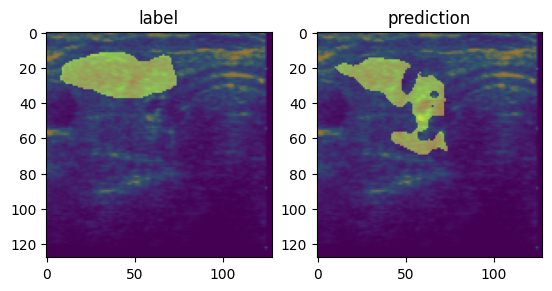

In [95]:
index = 20
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.imshow(mask[index][0], alpha = 0.5)
plt.title("label")

outputs = outputs>0.5
plt.subplot(1,2,2)
plt.imshow(image[index][0])
plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
plt.title("prediction")